In [1]:
import pickle

import sys
sys.path.append('/home/akashm/PROJECT/Hiwi_qml/qcbm/model_local_no_pretraining/')
from vqc_decoder_model_and_circuit import *

from jax.lib import xla_bridge
jax.experimental.enable_x64()
print("JAX Backend:", xla_bridge.get_backend().platform)

JAX Backend: gpu


In [2]:
# Saving the AntiCat distribution
with open('/home/akashm/PROJECT/Hiwi_qml/qcbm/cat_anticat/4qubit_anticat_distribution.pkl',"rb") as file2:
    anticat_data = pickle.load(file2)

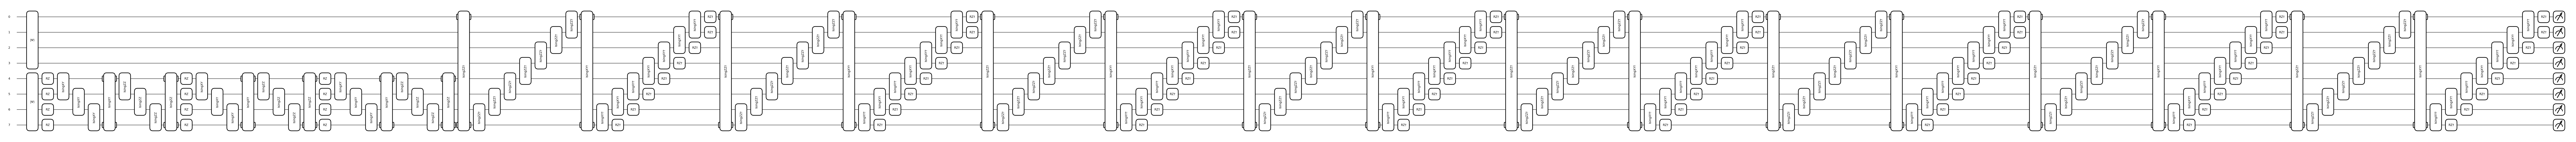

In [3]:
qml.draw_mpl(circuit,device='default')(input_params=initial_params)
plt.show()

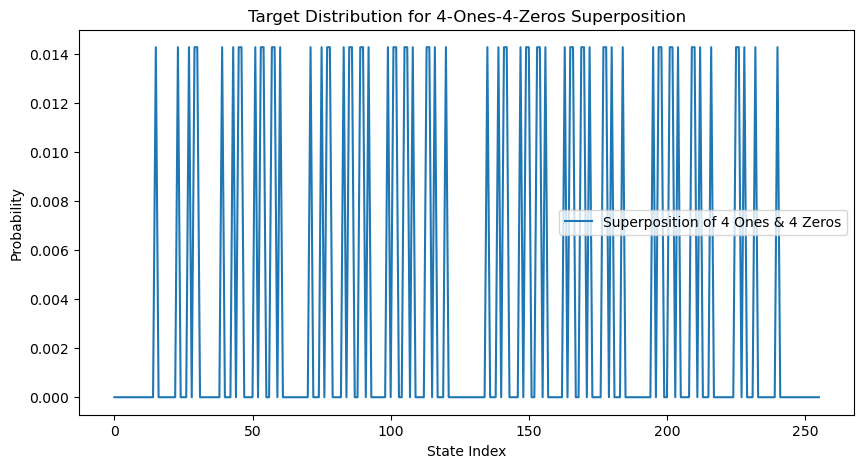

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

# Number of qubits
num_qubits = 8

# Generate all binary states with exactly 4 ones
valid_states = ["".join("1" if i in comb else "0" for i in range(num_qubits)) 
                for comb in combinations(range(num_qubits), 4)]

# Convert binary states to decimal indices
valid_indices = [int(state, 2) for state in valid_states]

# Create target distribution
target_distribution = np.zeros(2**num_qubits)
for index in valid_indices:
    target_distribution[index] = 1  # Assign probability 1 to valid states

# Normalize the distribution
target_distribution /= np.sum(target_distribution)

# Plot the target distribution
plt.figure(figsize=(10, 5))
plt.plot(target_distribution, linestyle="-", label="Superposition of 4 Ones & 4 Zeros")
plt.xlabel("State Index")
plt.ylabel("Probability")
plt.title("Target Distribution for 4-Ones-4-Zeros Superposition")
plt.legend()
plt.show()


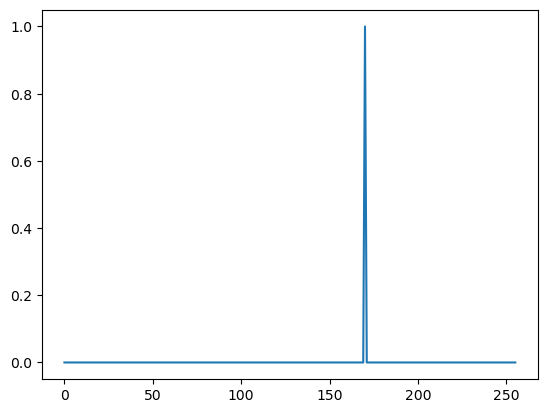

In [8]:
# import numpy as np

# Target binary pattern
target_binary = "10101010"
# Convert binary to decimal index
target_index = int(target_binary, 2)

# Create a one-hot encoded target distribution
num_qubits = 8
target_distribution = np.zeros(2**num_qubits)
target_distribution[target_index] = 1

plt.plot(target_distribution)

In [6]:
class MMD:
    def __init__(self,scales,space):
        gammas = 1/(2*(scales**2)).reshape(-1,1,1)
        sq_dists = jnp.abs(space[:,None] - space[None,:])**2
        self.K = jnp.sum(jnp.exp(-gammas * sq_dists), axis=0)/len(scales)
        self.scales = scales
        
    def k_expval(self,px,py):
        return px @ self.K @ py
    
    def __call__(self,px,py):
        pxy = px-py
        return self.k_expval(pxy,pxy)
    
class QCBM:
    def __init__(self,circ,mmd,py):
        self.circ = circ
        self.mmd = mmd
        self.py = py
    
    def mmd_loss(self,params):
        px = self.circ(params)
        return self.mmd(px,self.py), px
    

#Model Training
@jit
def update_step(params,opt_state):
    
    (loss_val,qcbm_probs), grads = jax.value_and_grad(qcbm.mmd_loss,has_aux=True)(params)

    updates,opt_state = opt.update(grads,opt_state)
    params = optax.apply_updates(params,updates)
    
    qcbm_probs = jnp.asarray(qcbm_probs, dtype=jnp.float64)
    
    kl_div = -jnp.sum(target_distribution * jnp.nan_to_num(jnp.log(qcbm_probs) - jnp.log(target_distribution)))
    
    return params, opt_state, loss_val, kl_div


### Cells to be run if the target_distribution corresponds to superposition of all half filled states

In [7]:
#Calling MMD class
bandwidth = jnp.array([0.25,60],dtype=jnp.float64)
space = jnp.arange(0,2**total_qubits,dtype=jnp.float64)
mmd = MMD(bandwidth,space=space)


#Calling QCBM class to run the previous built circuit with random weights
qcbm = QCBM(circuit,mmd=mmd,py=target_distribution)


#Initial parameters
weights = initial_params
lr = optax.exponential_decay(init_value=0.1,transition_steps=10,decay_rate=0.99,transition_begin=300,end_value=0.025,staircase=True)
# lr = 0.01
opt = optax.adam(learning_rate=lr)
opt_state = opt.init(weights)


history = []
divs = []
parameters = []


kl_div = 1
i = 0
# i = start_epoch

# while kl_div > 10^-3:
while i < 10001:
    i+=1
    current_lr = lr(i)
    # current_lr = lr
    start_time = time.time()
    weights, opt_state, loss_val, kl_div = update_step(params=weights,opt_state=opt_state)
    end_time = time.time()
    
    if i%10==0:
        print(f"Step: {i} Loss: {loss_val} KL_div:{kl_div} current_lr:{current_lr} Time taken per iteration: {end_time-start_time}")
    
    history.append(loss_val)
    divs.append(kl_div)
    parameters.append(weights)
    

Step: 10 Loss: 0.006870449520647526 KL_div:1.5950517654418945 current_lr:0.10000000149011612 Time taken per iteration: 0.0039234161376953125
Step: 20 Loss: 0.005369754508137703 KL_div:1.3177576065063477 current_lr:0.10000000149011612 Time taken per iteration: 0.0035712718963623047
Step: 30 Loss: 0.004992440342903137 KL_div:1.2168751955032349 current_lr:0.10000000149011612 Time taken per iteration: 0.004560232162475586
Step: 40 Loss: 0.004762163385748863 KL_div:1.1386845111846924 current_lr:0.10000000149011612 Time taken per iteration: 0.0056095123291015625
Step: 50 Loss: 0.004636900033801794 KL_div:1.0996938943862915 current_lr:0.10000000149011612 Time taken per iteration: 0.006178617477416992
Step: 60 Loss: 0.004565896466374397 KL_div:1.0910347700119019 current_lr:0.10000000149011612 Time taken per iteration: 0.00503087043762207
Step: 70 Loss: 0.004517578519880772 KL_div:1.0649151802062988 current_lr:0.10000000149011612 Time taken per iteration: 0.005995273590087891
Step: 80 Loss: 0.0

In [37]:
fig, axs = plt.subplots(1,2,figsize=(15,8))
axs[0].plot(divs)
axs[0].title.set_text('KL Divergence')

axs[1].plot(history)
axs[1].title.set_text('loss')

In [38]:
optimal_params = parameters[np.argmin(divs)]

qcbm_probs = circuit(optimal_params)
x_array = jnp.arange(0,2**(total_qubits),dtype=jnp.float64)


plt.bar(x_array,qcbm_probs,color='green',alpha=0.5,label='Obtained Cat')
# plt.plot(x_array,target_distribution,color='blue',alpha=0.5,label='Original Cat')
# axs[0].title.set_text('Target Distribution')

### Cells to be run if target_distribution is only 10101010

In [9]:
#Calling MMD class
bandwidth = jnp.array([0.25,60],dtype=jnp.float64)
space = jnp.arange(0,2**total_qubits,dtype=jnp.float64)
mmd = MMD(bandwidth,space=space)


#Calling QCBM class to run the previous built circuit with random weights
qcbm = QCBM(circuit,mmd=mmd,py=target_distribution)


#Initial parameters
weights = initial_params
lr = optax.exponential_decay(init_value=0.1,transition_steps=10,decay_rate=0.99,transition_begin=300,end_value=0.025,staircase=True)
# lr = 0.01
opt = optax.adam(learning_rate=lr)
opt_state = opt.init(weights)


history = []
divs = []
parameters = []


kl_div = 1
i = 0
# i = start_epoch

# while kl_div > 10^-3:
while i < 10001:
    i+=1
    current_lr = lr(i)
    # current_lr = lr
    start_time = time.time()
    weights, opt_state, loss_val, kl_div = update_step(params=weights,opt_state=opt_state)
    end_time = time.time()
    
    if i%10==0:
        print(f"Step: {i} Loss: {loss_val} KL_div:{kl_div} current_lr:{current_lr} Time taken per iteration: {end_time-start_time}")
    
    history.append(loss_val)
    divs.append(kl_div)
    parameters.append(weights)
    

Step: 10 Loss: 0.006870449520647526 KL_div:1.5950517654418945 current_lr:0.10000000149011612 Time taken per iteration: 0.0036559104919433594
Step: 20 Loss: 0.005369754508137703 KL_div:1.3177576065063477 current_lr:0.10000000149011612 Time taken per iteration: 0.004045248031616211
Step: 30 Loss: 0.004992440342903137 KL_div:1.2168751955032349 current_lr:0.10000000149011612 Time taken per iteration: 0.00360107421875
Step: 40 Loss: 0.004762163385748863 KL_div:1.1386845111846924 current_lr:0.10000000149011612 Time taken per iteration: 0.0039479732513427734
Step: 50 Loss: 0.004636900033801794 KL_div:1.0996938943862915 current_lr:0.10000000149011612 Time taken per iteration: 0.0033614635467529297
Step: 60 Loss: 0.004565896466374397 KL_div:1.0910347700119019 current_lr:0.10000000149011612 Time taken per iteration: 0.0038912296295166016
Step: 70 Loss: 0.004517578519880772 KL_div:1.0649151802062988 current_lr:0.10000000149011612 Time taken per iteration: 0.003259420394897461
Step: 80 Loss: 0.004

In [40]:
fig, axs = plt.subplots(1,2,figsize=(15,8))
axs[0].plot(divs)
axs[0].title.set_text('KL Divergence')

axs[1].plot(history)
axs[1].title.set_text('loss')

In [41]:
optimal_params = parameters[np.argmin(divs)]

qcbm_probs = circuit(optimal_params)
x_array = jnp.arange(0,2**(total_qubits),dtype=jnp.float64)


plt.bar(x_array,qcbm_probs,color='green',alpha=0.5,label='Obtained Cat')
# plt.plot(x_array,target_distribution,color='blue',alpha=0.5,label='Original Cat')
# axs[0].title.set_text('Target Distribution')

In [42]:
print(f"Minimum KL Divergence obtained is {np.min(divs)}")

In [43]:
#Save Checkpoint
checkpoint = {"final_epoch":i,
              "history":history,
              "divs":divs,
              "parameters":parameters}

with open(f'model_cat_anticat_distribution.pkl','wb') as file:
    pickle.dump(checkpoint,file)
    
print("Model saved successfully")